In [1]:
import pandas as pd
import numpy as np
import os

# seaborn可视化
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", style="darkgrid", 
        palette="deep", font="sans-serif", 
        font_scale=1, color_codes=True)

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
#setup the maximum display of columns to see what feature we may wanna use
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('final_data.csv')
df.head(10)

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,gender,start_month,start_day,start_hour,start_minute,start_second,stop_month,stop_day,stop_hour,stop_minute,stop_second,temp,feelslike,humidity,snowdepth,windspeed,visibility,start_weekday,start_quarter,age,distance
0,325.0,2016-08-17 09:47:41,2016-08-17 09:53:06,441.0,E 52 St & 2 Ave,40.756014,-73.967416,3142.0,1 Ave & E 62 St,40.761227,-73.960940,22164.0,1.0,2.0,8,17,9,47,41,8,17,9,53,6,25.9,25.9,71.16,0.0,9.8,14.8,2,3,72.0,796.362065
1,746.0,2016-06-03 21:01:32,2016-06-03 21:13:59,393.0,E 5 St & Avenue C,40.722992,-73.979955,545.0,E 23 St & 1 Ave,40.736502,-73.978095,14922.0,1.0,2.0,6,3,21,1,32,6,3,21,13,59,19.7,19.7,80.21,0.0,8.3,14.2,4,2,29.0,1508.464328
2,749.0,2016-07-11 18:15:39,2016-07-11 18:28:08,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,418.0,Front St & Gold St,40.702240,-73.982578,21479.0,1.0,2.0,7,11,18,15,39,7,11,18,28,8,26.9,26.9,43.36,0.0,9.1,16.0,0,3,46.0,1772.886614
3,139.0,2016-05-31 08:05:46,2016-05-31 08:08:06,315.0,South St & Gouverneur Ln,40.703554,-74.006702,259.0,South St & Whitehall St,40.701221,-74.012342,17057.0,1.0,1.0,5,31,8,5,46,5,31,8,8,6,23.1,23.1,76.87,0.0,8.1,12.9,1,2,42.0,542.474970
4,532.0,2016-06-17 19:56:12,2016-06-17 20:05:05,3117.0,Franklin St & Dupont St,40.735640,-73.958660,3092.0,Berry St & N 8 St,40.719009,-73.958525,23843.0,1.0,1.0,6,17,19,56,12,6,17,20,5,5,21.8,21.8,35.94,0.0,9.6,16.0,4,2,31.0,1846.829562
5,1379.0,2016-04-19 21:25:34,2016-04-19 21:48:34,150.0,E 2 St & Avenue C,40.720874,-73.980858,459.0,W 20 St & 11 Ave,40.746745,-74.007756,14978.0,1.0,1.0,4,19,21,25,34,4,19,21,48,34,17.3,17.3,18.13,0.0,22.8,16.0,1,2,35.0,3662.885700
6,428.0,2016-04-18 19:52:07,2016-04-18 19:59:16,225.0,W 14 St & The High Line,40.741951,-74.008030,482.0,W 15 St & 7 Ave,40.739355,-73.999318,16701.0,1.0,2.0,4,18,19,52,7,4,18,19,59,16,21.8,21.8,19.82,0.0,17.4,16.0,0,2,32.0,790.328353
7,104.0,2016-12-03 11:55:25,2016-12-03 11:57:09,253.0,W 13 St & 5 Ave,40.735439,-73.994539,280.0,E 10 St & 5 Ave,40.733320,-73.995101,26357.0,1.0,1.0,12,3,11,55,25,12,3,11,57,9,7.3,3.6,45.17,0.0,24.5,16.0,5,4,62.0,240.123630
8,784.0,2016-01-05 12:33:53,2016-01-05 12:46:58,279.0,Peck Slip & Front St,40.707873,-74.001670,400.0,Pitt St & Stanton St,40.719261,-73.981780,21366.0,1.0,1.0,1,5,12,33,53,1,5,12,46,58,-5.4,-11.3,31.37,0.0,16.0,16.0,1,1,73.0,2103.282897
9,1294.0,2016-09-04 12:50:48,2016-09-04 13:12:22,471.0,Grand St & Havemeyer St,40.712868,-73.956981,471.0,Grand St & Havemeyer St,40.712868,-73.956981,26938.0,1.0,1.0,9,4,12,50,48,9,4,13,12,22,23.5,23.5,50.06,0.0,15.0,16.0,6,3,31.0,0.000000


In [18]:
df_selected = df[['starttime', 'temp', 'feelslike', 'humidity', 'windspeed', 
                  'start_weekday', 'start_month', 'start_hour']].copy()
df_selected['starttime'] = pd.to_datetime(df_selected['starttime'])


In [20]:
df_selected['date'] = df_selected['starttime'].dt.date
df_selected['hour'] = df_selected['starttime'].dt.hour
df_selected['month'] = df_selected['starttime'].dt.month
df_selected['day_of_week'] = df_selected['starttime'].dt.dayofweek  # 星期一为0，星期日为6

# 创建 'is_weekend' 列，标识是否为周末
df_selected['is_weekend'] = df_selected['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 定义一个函数来确定季节
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'  # 冬季
    elif month in [3, 4, 5]:
        return 'Spring'  # 春季
    elif month in [6, 7, 8]:
        return 'Summer'  # 夏季
    else:
        return 'Fall'    # 秋季

# 应用函数来创建 'season' 列
df_selected['season'] = df_selected['start_month'].apply(get_season)


In [22]:
# 按 'date' 和 'hour' 分组，计算出行量和平均湿度、风速
grouped = df_selected.groupby(['date', 'hour']).agg({
    'starttime': 'count',         # 出行次数
    'temp': 'mean',               # 平均温度
    'feelslike': 'mean',          # 平均体感温度
    'humidity': 'mean',           # 平均湿度
    'windspeed': 'mean',          # 平均风速
    'is_weekend': 'first',        # 是否为周末
    'season': 'first',            # 季节
    'start_month': 'first',       # 月份
    'day_of_week': 'first'        # 星期几
}).reset_index()

# 重命名 'tripduration' 列为 'trip_count'
grouped.rename(columns={
    'starttime': 'trip_count',
    'start_month': 'month'
}, inplace=True)



In [ ]:
# 10. 添加'Month'列（月份的名称）
grouped['Month'] = grouped['month'].apply(lambda x: pd.Timestamp(2021, x, 1).strftime('%B'))
# 11. 查看聚合后的数据
print(grouped.head())

         date  hour  trip_count  temp  feelslike  humidity  windspeed  \
0  2016-01-01     0         225   5.8        3.5     54.08       11.1   
1  2016-01-01     1         311   5.8        3.0     53.01       13.0   
2  2016-01-01     2         260   5.4        2.7     54.71       12.1   
3  2016-01-01     3         201   5.1        2.4     56.04       12.2   
4  2016-01-01     4          76   5.1        1.7     55.70       16.6   

   is_weekend  season  month  day_of_week    Month  
0           0  Winter      1            4  January  
1           0  Winter      1            4  January  
2           0  Winter      1            4  January  
3           0  Winter      1            4  January  
4           0  Winter      1            4  January  


In [30]:
grouped['date'] = pd.to_datetime(grouped['date'])
grouped.dtypes

date           datetime64[ns]
hour                    int32
trip_count              int64
temp                  float64
feelslike             float64
humidity              float64
windspeed             float64
is_weekend              int64
season                 object
month                   int64
day_of_week             int32
Month                  object
dtype: object

In [31]:
data = grouped.set_index('date')
data.head()

,hour,trip_count,temp,feelslike,humidity,windspeed,is_weekend,season,month,day_of_week,Month
date,,,,,,,,,,,
2016-01-01,0,225,5.8,3.5,54.08,11.1,0,Winter,1,4,January
2016-01-01,1,311,5.8,3.0,53.01,13.0,0,Winter,1,4,January
2016-01-01,2,260,5.4,2.7,54.71,12.1,0,Winter,1,4,January
2016-01-01,3,201,5.1,2.4,56.04,12.2,0,Winter,1,4,January
2016-01-01,4,76,5.1,1.7,55.70,16.6,0,Winter,1,4,January


In [40]:
data["day_of_month"] = data.index.day
data['month'] = data.index.month
data.columns

Index(['hour', 'trip_count', 'temp', 'feelslike', 'humidity', 'windspeed',
       'is_weekend', 'season', 'month', 'day_of_week', 'Month',
       'day_of_month'],
      dtype='object')

In [41]:
data.head(10)

,hour,trip_count,temp,feelslike,humidity,windspeed,is_weekend,season,month,day_of_week,Month,day_of_month
date,,,,,,,,,,,,
2016-01-01,0,225,5.8,3.5,54.08,11.1,0,Winter,1,4,January,1
2016-01-01,1,311,5.8,3.0,53.01,13.0,0,Winter,1,4,January,1
2016-01-01,2,260,5.4,2.7,54.71,12.1,0,Winter,1,4,January,1
2016-01-01,3,201,5.1,2.4,56.04,12.2,0,Winter,1,4,January,1
2016-01-01,4,76,5.1,1.7,55.70,16.6,0,Winter,1,4,January,1
2016-01-01,5,45,4.5,0.7,58.90,18.4,0,Winter,1,4,January,1
2016-01-01,6,64,4.5,1.2,58.45,14.8,0,Winter,1,4,January,1
2016-01-01,7,87,4.1,2.3,59.70,7.3,0,Winter,1,4,January,1
2016-01-01,8,152,4.1,1.1,57.57,12.7,0,Winter,1,4,January,1


In [42]:
season_mapping = {
    'Spring': 0,
    'Summer': 1,
    'Fall': 2,
    'Winter': 3
}
data['season'] = data['season'].map(season_mapping)

In [47]:
data['month'] = data.index.month

#drop Month column
data.drop(['Month'], axis=1, inplace=True)


In [125]:
data.head(10)

,hour,trip_count,temp,feelslike,humidity,windspeed,is_weekend,season,month,day_of_week,day_of_month
date,,,,,,,,,,,
2016-01-01,0,225,5.8,3.5,54.08,11.1,0,3,1,4,1
2016-01-01,1,311,5.8,3.0,53.01,13.0,0,3,1,4,1
2016-01-01,2,260,5.4,2.7,54.71,12.1,0,3,1,4,1
2016-01-01,3,201,5.1,2.4,56.04,12.2,0,3,1,4,1
2016-01-01,4,76,5.1,1.7,55.70,16.6,0,3,1,4,1
2016-01-01,5,45,4.5,0.7,58.90,18.4,0,3,1,4,1
2016-01-01,6,64,4.5,1.2,58.45,14.8,0,3,1,4,1
2016-01-01,7,87,4.1,2.3,59.70,7.3,0,3,1,4,1
2016-01-01,8,152,4.1,1.1,57.57,12.7,0,3,1,4,1


In [126]:
data.dtypes

hour              int32
trip_count        int64
temp            float64
feelslike       float64
humidity        float64
windspeed       float64
is_weekend        int64
season            int64
month             int32
day_of_week       int32
day_of_month      int32
dtype: object

In [124]:
#drop humidity_bins column and windspeed_bins column
data.drop(['windspeed_bin'], axis=1, inplace=True)
data.drop(['month_sin'], axis=1, inplace=True)
data.drop(['month_cos'], axis=1, inplace=True)


# Corraltion

In [50]:
corr_matrix = data.corr().abs()
corr_matrix

,hour,trip_count,temp,feelslike,humidity,windspeed,is_weekend,season,month,day_of_week,day_of_month
hour,1.000000,0.355539,0.120485,0.112765,0.222326,0.131117,0.000169,0.000701,0.001251,0.000100,0.000810
trip_count,0.355539,1.000000,0.361631,0.354352,0.202515,0.027904,0.186763,0.085783,0.173791,0.145034,0.009102
temp,0.120485,0.361631,1.000000,0.994004,0.099883,0.235886,0.016149,0.421488,0.241419,0.004406,0.066083
feelslike,0.112765,0.354352,0.994004,1.000000,0.120113,0.282970,0.013311,0.430019,0.246689,0.000346,0.058284
humidity,0.222326,0.202515,0.099883,0.120113,1.000000,0.213736,0.011286,0.023182,0.184221,0.005102,0.037436
windspeed,0.131117,0.027904,0.235886,0.282970,0.213736,1.000000,0.006230,0.115935,0.094885,0.016775,0.000467
is_weekend,0.000169,0.186763,0.016149,0.013311,0.011286,0.006230,1.000000,0.004914,0.002973,0.787597,0.005294
season,0.000701,0.085783,0.421488,0.430019,0.023182,0.115935,0.004914,1.000000,0.232323,0.016227,0.024042
month,0.001251,0.173791,0.241419,0.246689,0.184221,0.094885,0.002973,0.232323,1.000000,0.002929,0.025397
day_of_week,0.000100,0.145034,0.004406,0.000346,0.005102,0.016775,0.787597,0.016227,0.002929,1.000000,0.004925


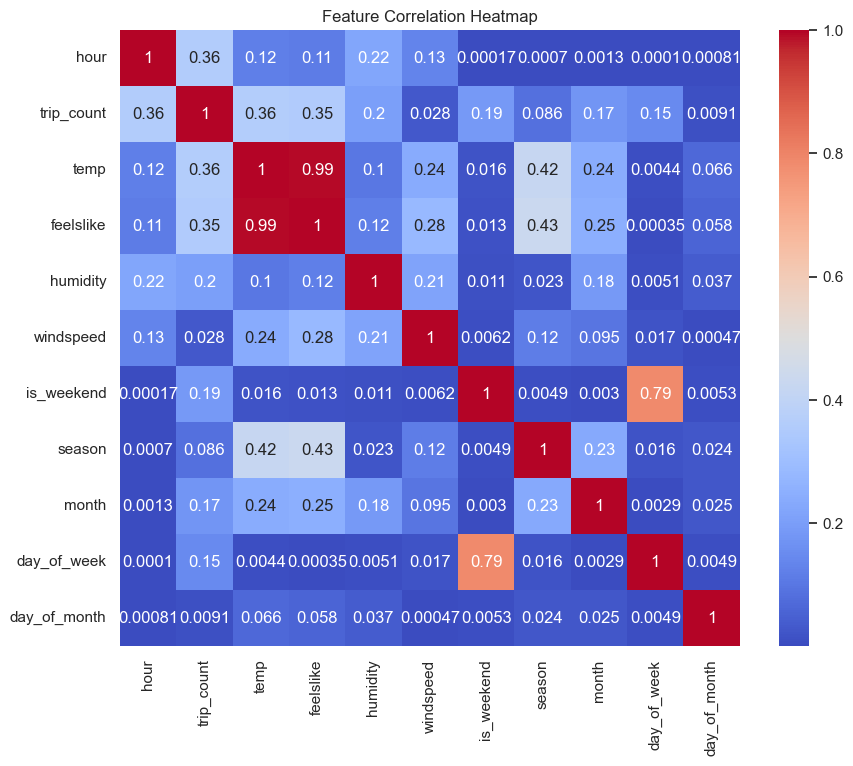

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [52]:
data.isnull().sum()

hour            0
trip_count      0
temp            0
feelslike       0
humidity        0
windspeed       0
is_weekend      0
season          0
month           0
day_of_week     0
day_of_month    0
dtype: int64

(array([16801., 16861., 16922., 16983., 17045., 17106., 17167.]),
 [Text(16801.0, 0, '2016-01'),
  Text(16861.0, 0, '2016-03'),
  Text(16922.0, 0, '2016-05'),
  Text(16983.0, 0, '2016-07'),
  Text(17045.0, 0, '2016-09'),
  Text(17106.0, 0, '2016-11'),
  Text(17167.0, 0, '2017-01')])

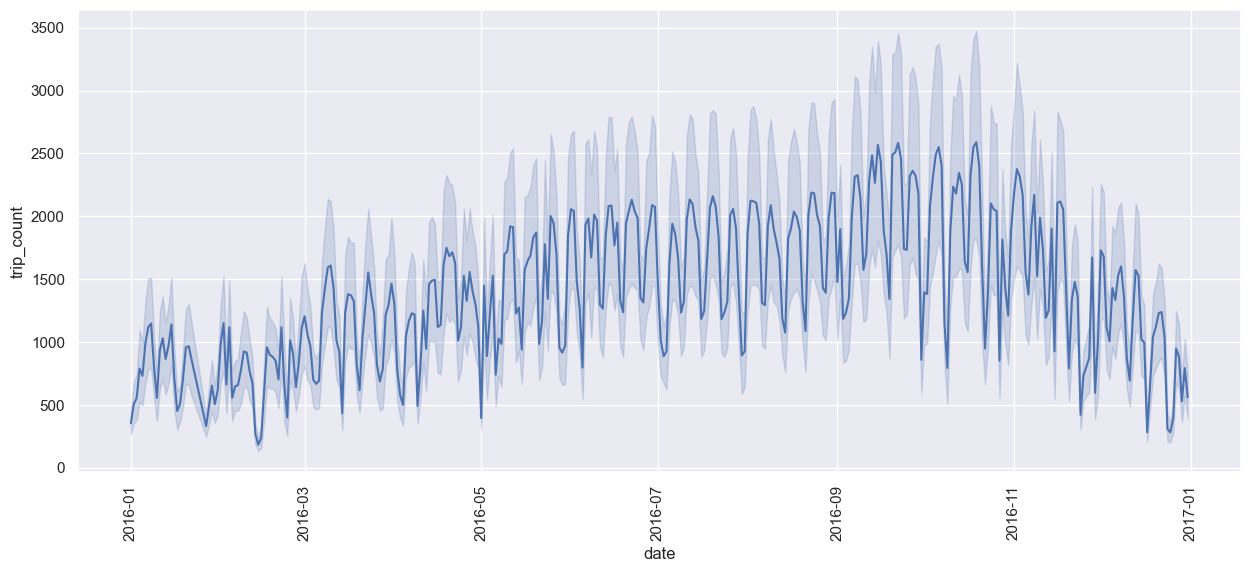

In [53]:
plt.figure(figsize=(15,6))

sns.lineplot(data=data,  # 传入数据
             x=data.index,  # 时间
             y=data.trip_count  # 需求量
            )

plt.xticks(rotation=90)


In [55]:
df_by_month = data.resample('M').sum()
df_by_month.head()

,hour,trip_count,temp,feelslike,humidity,windspeed,is_weekend,season,month,day_of_week,day_of_month
date,,,,,,,,,,,
2016-01-31,7446,484933,1069.9,-1199.0,32889.06,9196.2,192,1932,644,2080,9444
2016-02-29,8004,531048,2239.9,55.1,38782.92,10342.1,192,2088,1392,2016,10440
2016-03-31,8554,826678,6735.8,5521.8,38589.65,10008.5,191,0,2229,2154,11891
2016-04-30,8280,882679,8268.7,7506.7,35939.52,8970.7,216,0,2880,2232,11160
2016-05-31,8556,1035959,12587.0,12421.2,45874.36,8191.3,216,0,3720,2184,11904


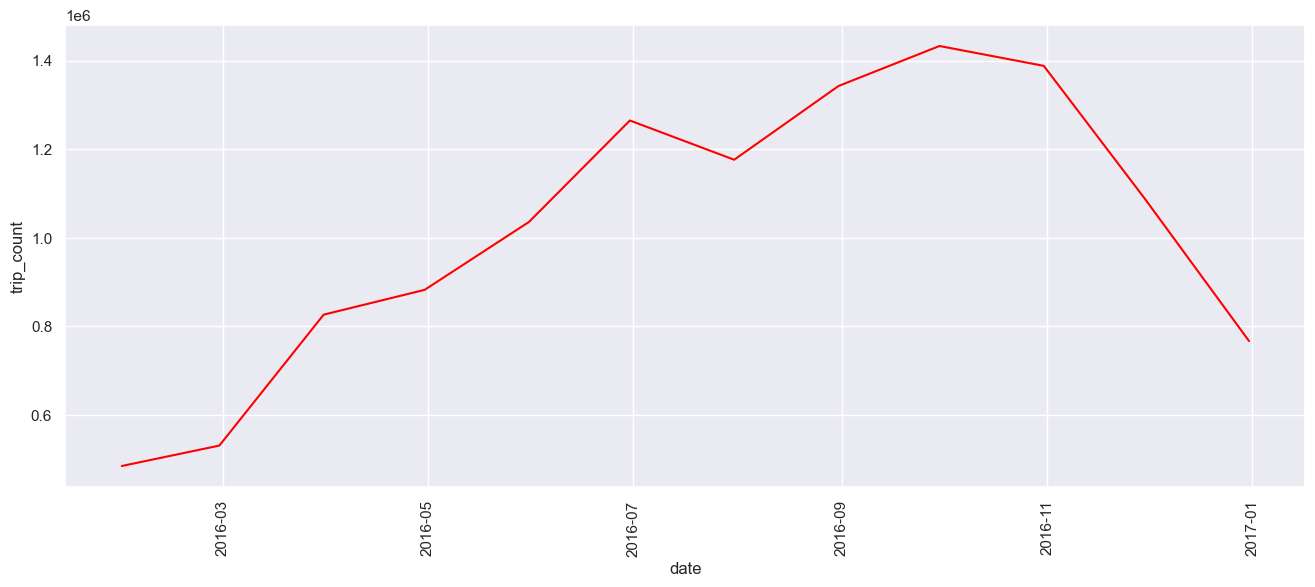

In [57]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df_by_month,
             x=df_by_month.index,
             y=df_by_month.trip_count,
             color="red"
            )

plt.xticks(rotation=90)

plt.show()


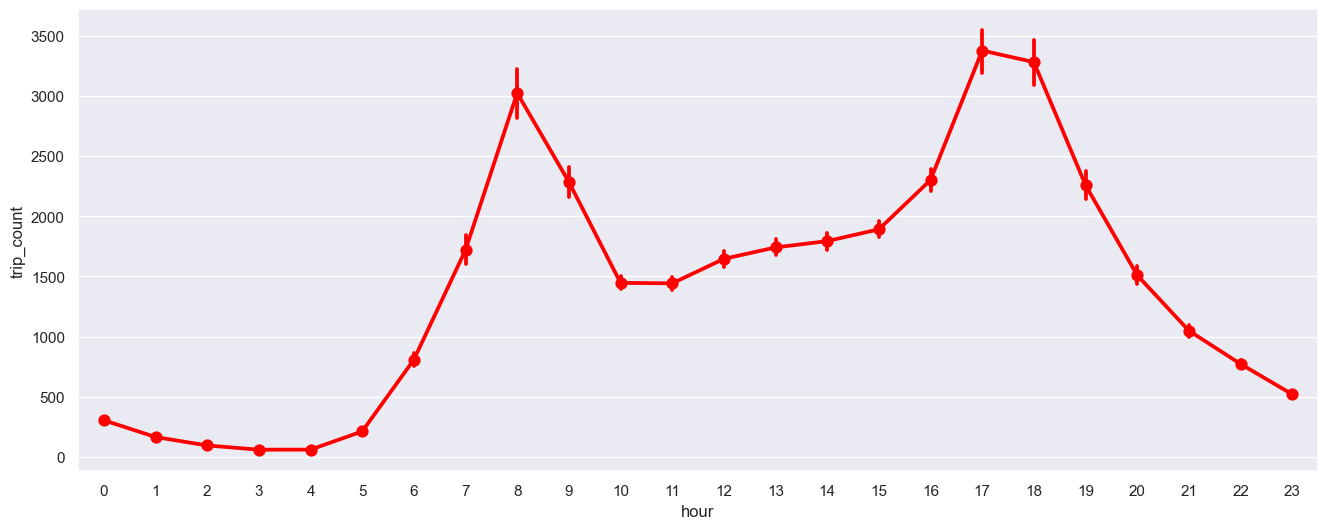

In [58]:
plt.figure(figsize=(16,6))

sns.pointplot(data=data,  # 数据
              x=data.hour,  # 小时
              y=data.trip_count,  # 需求量
              color="red"  # 颜色
             )

plt.show()


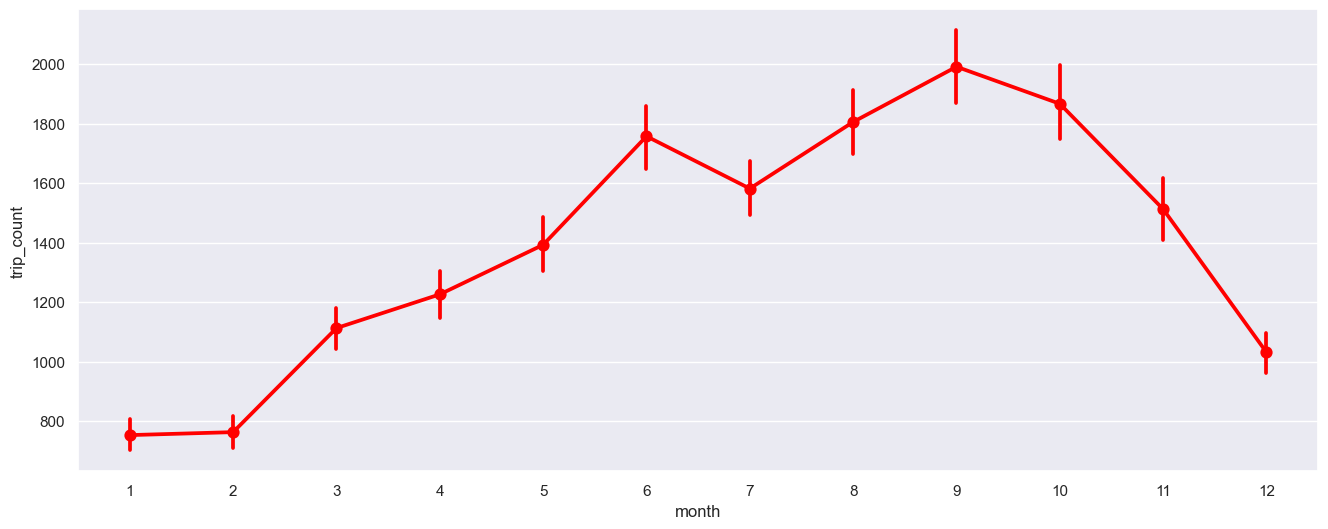

In [59]:
plt.figure(figsize=(16,6))

sns.pointplot(data=data,
              x=data.month,
              y=data.trip_count,
              color="red"
             )
plt.show()


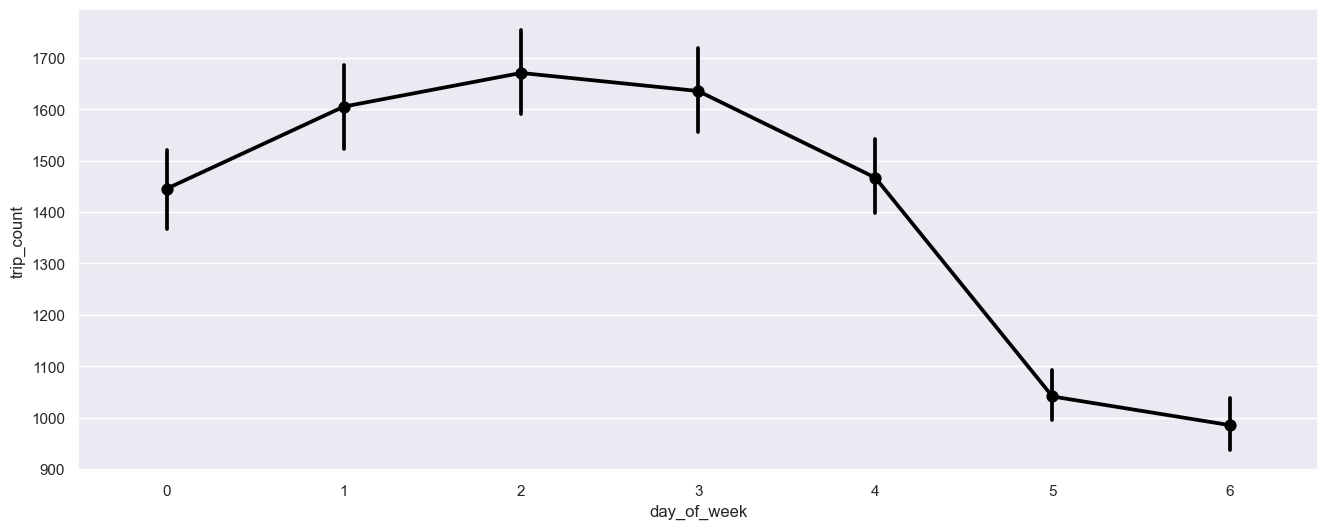

In [60]:
plt.figure(figsize=(16,6))

sns.pointplot(data=data,
              x=data.day_of_week,
              y=data.trip_count,
              color="black")

plt.show()


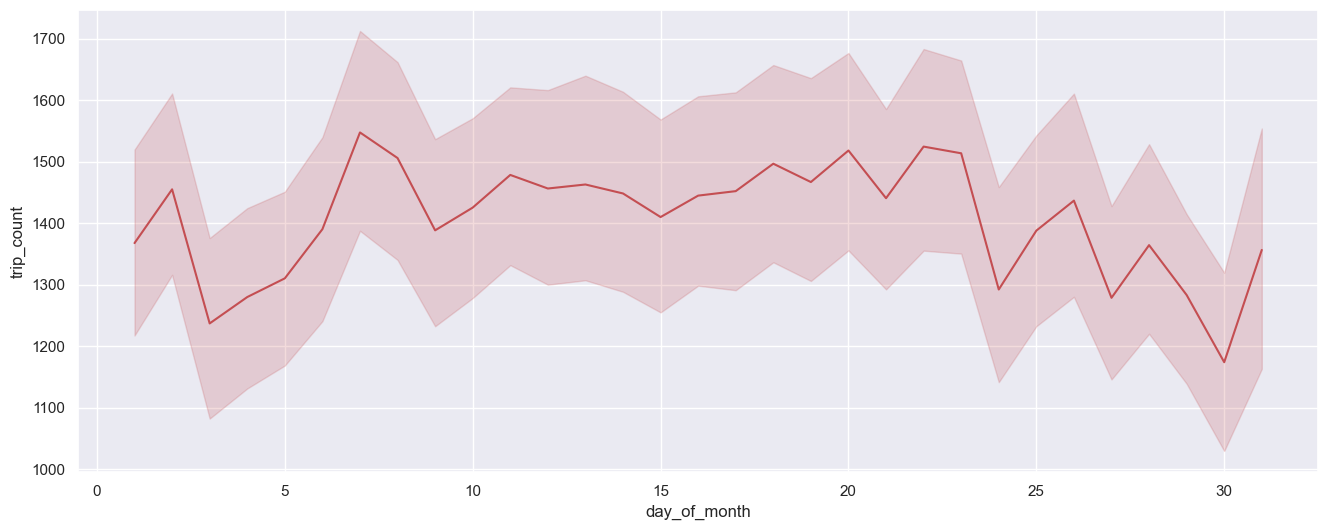

In [61]:
plt.figure(figsize=(16,6))

sns.lineplot(
  data=data,
  x=data.day_of_month,  # 一个月中的某天
  y=data.trip_count,  # 需求量
  color="r")

plt.show()


## Weather info

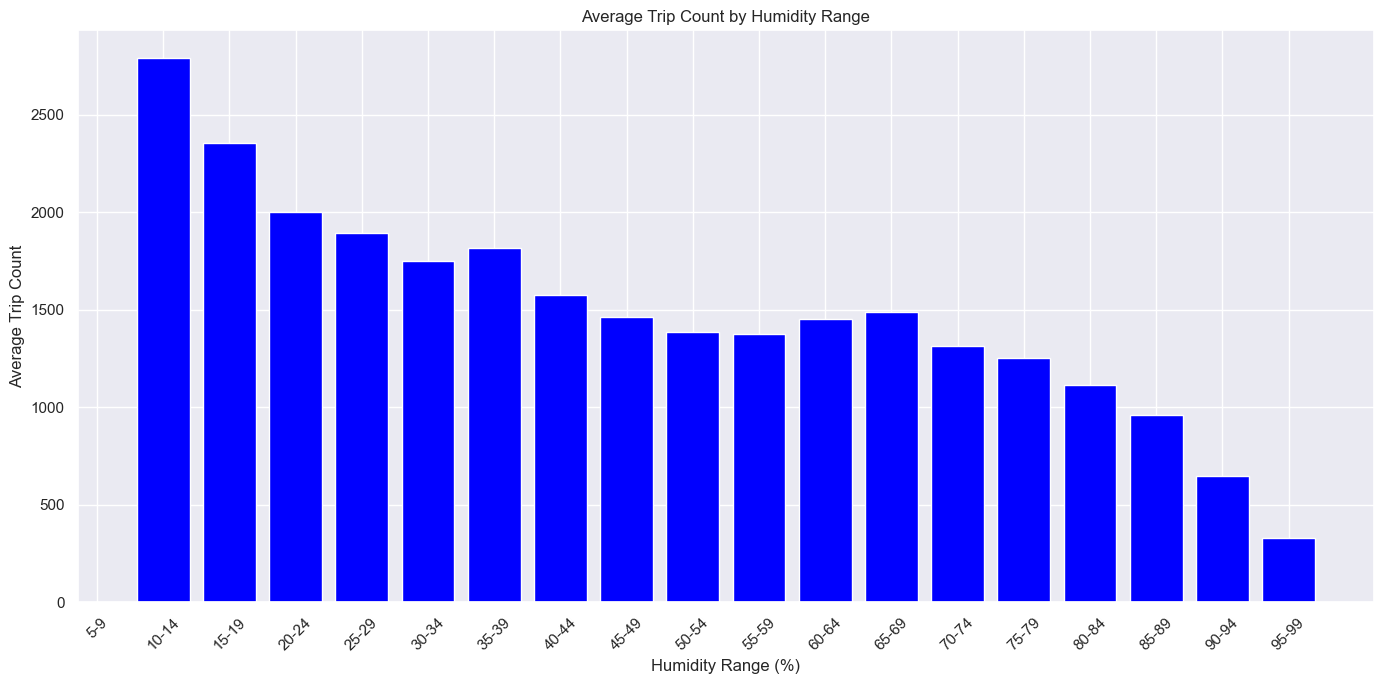

In [64]:
bin_intervals = np.arange(0, 105, 5)
bin_labels = [f"{i}-{i+4}" for i in range(0, 100, 5)]
data['humidity_bin'] = pd.cut(data['humidity'], bins=bin_intervals, labels=bin_labels, include_lowest=True)
average_trips_per_humidity_bin = data.groupby('humidity_bin')['trip_count'].mean().reset_index()

plt.figure(figsize=(14, 7))
plt.bar(average_trips_per_humidity_bin['humidity_bin'], average_trips_per_humidity_bin['trip_count'], color='blue')
plt.xlabel('Humidity Range (%)')
plt.ylabel('Average Trip Count')
plt.title('Average Trip Count by Humidity Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

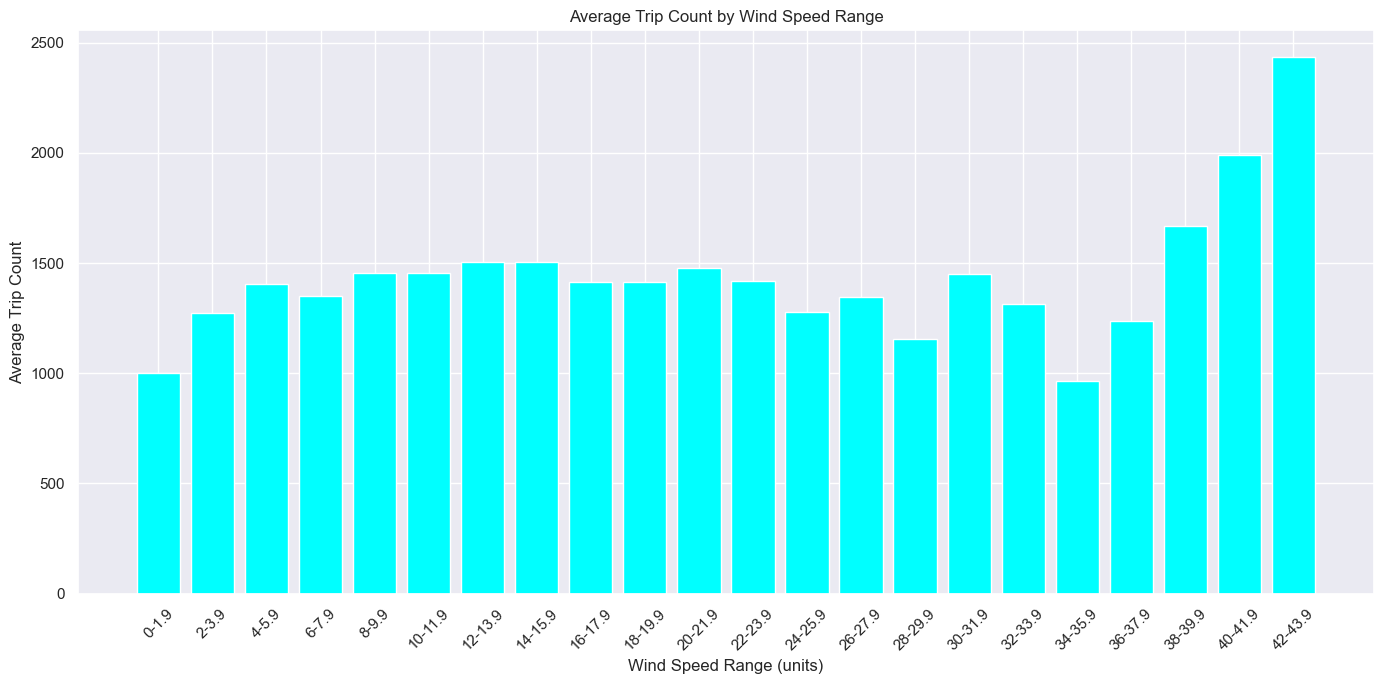

In [66]:
# windspeed
wind_speed_intervals = np.arange(0, data['windspeed'].max() + 2, 2)
wind_speed_labels = [f"{i}-{i+1.9}" for i in range(0, int(data['windspeed'].max() + 1), 2)]

# 将风速数据分组
data['windspeed_bin'] = pd.cut(data['windspeed'], bins=wind_speed_intervals, labels=wind_speed_labels, include_lowest=True)

# 计算每个风速区间的平均行程数
average_trips_per_windspeed_bin = data.groupby('windspeed_bin')['trip_count'].mean().reset_index()

# 生成条形图
plt.figure(figsize=(14, 7))
plt.bar(average_trips_per_windspeed_bin['windspeed_bin'], average_trips_per_windspeed_bin['trip_count'], color='cyan')
plt.xlabel('Wind Speed Range (units)')
plt.ylabel('Average Trip Count')
plt.title('Average Trip Count by Wind Speed Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Modeling

## Split test and valid

In [87]:
# 可以尝试周期性转换
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# 按日期排序
merged_data = data.sort_values('date')


In [88]:
features = [
    'hour', 'temp', 'humidity', 'feelslike', 
    'windspeed', 'is_weekend', 'season', 'month',
    'day_of_week', 'day_of_month']

In [89]:
# 切分数据集的模块
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train = train_data[features]
y_train = train_data['trip_count']

X_test = test_data[features]
y_test = test_data['trip_count']

# Linear Model

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

测试集均方误差（MSE）：1557332.1819509135


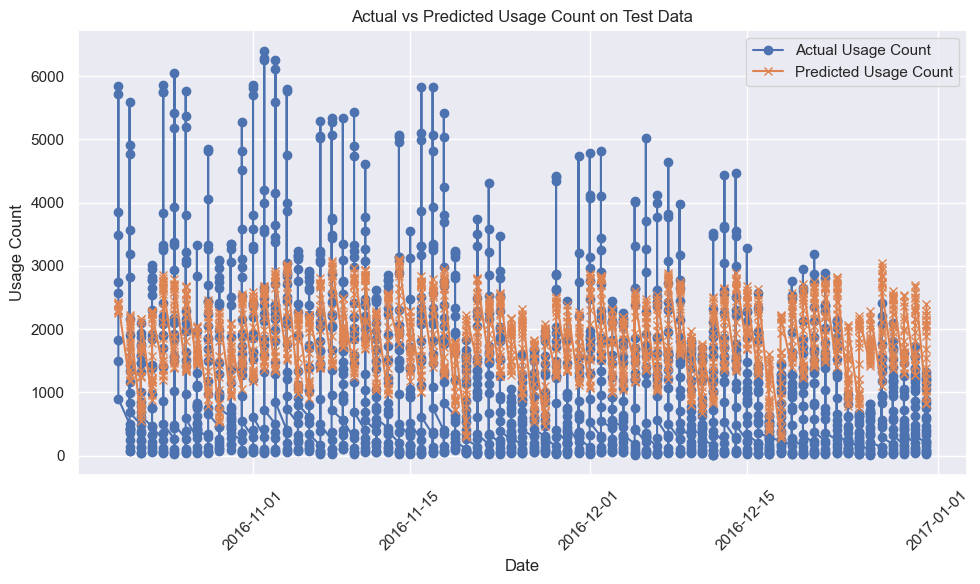

In [93]:
# 创建线性回归模型
model = LinearRegression()
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
print(f'测试集均方误差（MSE）：{mse}')

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test.values, label='Actual Usage Count', marker='o')
plt.plot(test_data.index, y_pred, label='Predicted Usage Count', marker='x')
plt.xlabel('Date')
plt.ylabel('Usage Count')
plt.title('Actual vs Predicted Usage Count on Test Data')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## LSTM

In [134]:
# 切分数据集的模块
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=0.2, random_state=0)
print(train.shape)
print(test.shape)


(6946, 11)
(1737, 11)


In [131]:
data.head()

,hour,trip_count,temp,feelslike,humidity,windspeed,is_weekend,season,month,day_of_week,day_of_month
date,,,,,,,,,,,
2016-01-01,0,225,5.8,3.5,54.08,11.1,0,3,1,4,1
2016-01-01,1,311,5.8,3.0,53.01,13.0,0,3,1,4,1
2016-01-01,2,260,5.4,2.7,54.71,12.1,0,3,1,4,1
2016-01-01,3,201,5.1,2.4,56.04,12.2,0,3,1,4,1
2016-01-01,4,76,5.1,1.7,55.70,16.6,0,3,1,4,1


In [132]:
data.dtypes

hour              int32
trip_count        int64
temp            float64
feelslike       float64
humidity        float64
windspeed       float64
is_weekend        int64
season            int64
month             int32
day_of_week       int32
day_of_month      int32
dtype: object

In [135]:
from sklearn.preprocessing import MinMaxScaler
# 实例化对象
scaler  = MinMaxScaler()

# 部分字段的拟合
num_col = ['temp', 'feelslike', 'humidity', 'windspeed']
trans_1 = scaler.fit(train[num_col].to_numpy())

# 训练集转换
train.loc[:,num_col] = trans_1.transform(train[num_col].to_numpy())
# 测试集转换
test.loc[:,num_col] = trans_1.transform(test[num_col].to_numpy())

# 对标签cnt的归一化
cnt_scaler = MinMaxScaler()
# 数据拟合
trans_2 = cnt_scaler.fit(train[["trip_count"]])
# 数据转化
train["trip_count"] = trans_2.transform(train[["trip_count"]])
test["trip_count"] = trans_2.transform(test[["trip_count"]])


In [136]:
# 用于显示进度条
import numpy as np
from tqdm import tqdm

def prepare_data(X, y, time_steps=1):
    Xs = []
    Ys = []
    
    for i in tqdm(range(len(X) - time_steps)):
        a = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(a)
        Ys.append(y.iloc[i + time_steps])
            
    return np.array(Xs), np.array(Ys)

steps = 24

X_train, y_train = prepare_data(train, train['trip_count'], time_steps=steps)
X_test, y_test = prepare_data(test, test['trip_count'], time_steps=steps)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


100%|██████████| 1713/1713 [00:00<00:00, 15508.64it/s]

(6922, 24, 11)
(1713, 24, 11)
(6922,)
(1713,)


In [137]:
# 1、导入需要的库
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# 2、实例化对象并拟合建模
model = Sequential()
model.add(Bidirectional(LSTM(128, 
                             input_shape=(X_train.shape[1],
                                          X_train.shape[2]))))

model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")



In [138]:
prepared_model = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test])

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0529 - val_loss: 0.0364
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0374 - val_loss: 0.0361
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0360 - val_loss: 0.0361
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0377 - val_loss: 0.0361
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0366 - val_loss: 0.0362
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0375 - val_loss: 0.0362
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0363 - val_loss: 0.0363
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0367 - val_loss: 0.0361
Epoch 9/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0361 - val_loss: 0.0362
Epoch 10/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0366 - val_loss: 0.0366
Epoch 11/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0360 - val_loss: 0.0362
Epoch 12/100
217/217 ━━━━━━━━━

Text(0, 0.5, 'mes score')

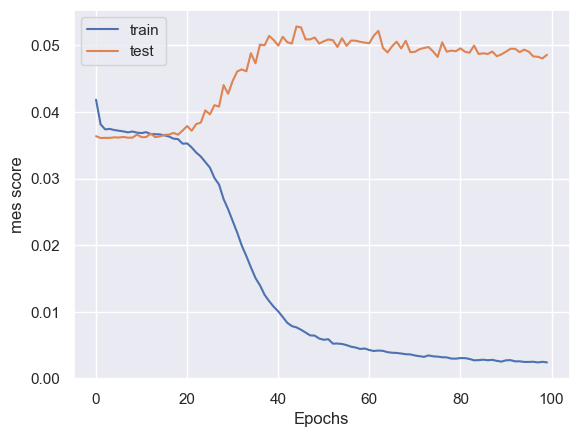

In [139]:
plt.plot(prepared_model.history['loss'], label='train')
plt.plot(prepared_model.history['val_loss'], label='test')

plt.legend(loc = "best")
plt.xlabel("Epochs")
plt.ylabel("mes score")

In [140]:
pred = model.predict(X_test)  # 对测试集预测 
y_test_inv = cnt_scaler.inverse_transform(y_test.reshape(-1,1))  # 转变数据
pred_inv = cnt_scaler.inverse_transform(pred)  # 预测值转换
pred_inv


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([[2814.7942 ],
       [ 717.27856],
       [ 820.178  ],
       ...,
       [ 643.002  ],
       [1363.1813 ],
       [1138.627  ]], dtype=float32)

In [ ]:
pred_inv.flatten()

array([2814.7942 ,  717.27856,  820.178  , ...,  643.002  , 1363.1813 ,
       1138.627  ], dtype=float32)

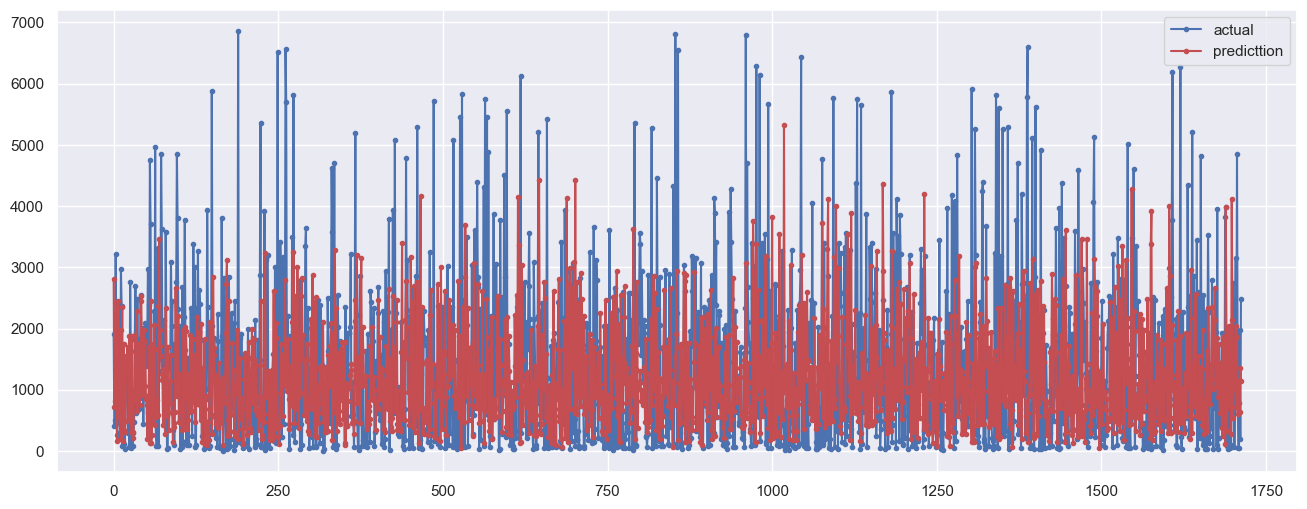

In [142]:
plt.figure(figsize=(16,6))

# 测试集：真实值
plt.plot(y_test_inv.flatten(), marker=".", label="actual")
# 模型预测值
plt.plot(pred_inv.flatten(), marker=".", label="predicttion",color="r")
# 图例位置
plt.legend(loc="best")
plt.show()


In [143]:
y_test_actual = cnt_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_pred = cnt_scaler.inverse_transform(pred)
final = pd.DataFrame({"actual": y_test_actual.flatten(),
                      "pred": y_test_pred.flatten()})
final.head()


,actual,pred
0,1904.0,2814.794189
1,401.0,717.278564
2,513.0,820.177979
3,3212.0,2148.443604
4,1726.0,2416.798340


In [144]:
# mse、r2_score
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(final.actual, final.pred))
r2 = r2_score(final.actual, final.pred)

print("rmse is : ", rmse)
print("-------")
print("r2_score is : ", r2)

rmse is :  1534.5599309559905
-------
r2_score is :  -0.349256002327226
